In [1]:
import pandas as pd
import numpy as np

In [2]:
#加载数据
articles_df = pd.read_csv("shared_articles.csv")
#仅考虑 被分享的内容
articles_df = articles_df[articles_df["eventType"] == "CONTENT SHARED"]
print(articles_df.shape)
articles_df.head()

(3047, 13)


,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en
5,1459194522,CONTENT SHARED,-2826566343807132236,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en


In [3]:
#interactions数据
interactions_df = pd.read_csv("users_interactions.csv")
interactions_df.head()

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN


In [4]:
#构建评价体系
event_type_strength = {
    "VIEW": 1.0,
    "LIKE": 2.0,
    "BOOKMARK": 2.5,
    "FOLLOW": 3.0,
    "COMMENT CREATED": 4.0,
}

In [5]:
#基于评价体系的评分标准，量化用户行为
interactions_df["eventStrength"] = interactions_df["eventType"].apply(lambda x: event_type_strength[x])
interactions_df.head()

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry,eventStrength
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN,1.0
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US,1.0
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN,1.0
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN,3.0
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN,1.0


In [6]:
#每个用户对不同文章的互动行为数量
users_interactions_count_df = interactions_df.groupby(["contentId","personId"]).size().groupby("personId").size()
users_interactions_count_df.head()

personId
-9223121837663643404    43
-9212075797126931087     5
-9207251133131336884     7
-9199575329909162940    11
-9196668942822132778     7
dtype: int64

In [7]:
#筛选与文章互动数超过5的用户
users_interactions_enough_count_df = users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[["personId"]]

In [8]:
#取出筛选后用户数据
interactions_from_selected_users_df = interactions_df.merge(users_interactions_enough_count_df,on="personId",how="inner")
print(interactions_from_selected_users_df.shape)

(69868, 9)


In [9]:
#用户可能会多次浏览评论同一篇文章，对互动分值加和取对数使分布趋近正态分布
import math
def smooth_user_preference(x):
    return math.log(1+x,2)

In [10]:
interactions_full_df = interactions_from_selected_users_df.groupby(
    ["personId","contentId"])["eventStrength"].sum().apply(smooth_user_preference).reset_index()
print(interactions_full_df.shape)
interactions_full_df.head()

(39106, 3)


,personId,contentId,eventStrength
0,-9223121837663643404,-8949113594875411859,1.000000
1,-9223121837663643404,-8377626164558006982,1.000000
2,-9223121837663643404,-8208801367848627943,1.000000
3,-9223121837663643404,-8187220755213888616,1.000000
4,-9223121837663643404,-7423191370472335463,3.169925


In [11]:
#使用personId作为索引
interactions_full_df.set_index("personId",inplace=True)
interactions_full_df.head()

,contentId,eventStrength
personId,,
-9223121837663643404,-8949113594875411859,1.000000
-9223121837663643404,-8377626164558006982,1.000000
-9223121837663643404,-8208801367848627943,1.000000
-9223121837663643404,-8187220755213888616,1.000000
-9223121837663643404,-7423191370472335463,3.169925


In [12]:
interactions_full_df["eventStrength"].max()

7.851749041416057

In [13]:
#划分训练集，测试集
from sklearn.model_selection import train_test_split

interactions_train_df,interactions_test_df = train_test_split(interactions_full_df,
                                                             stratify= interactions_full_df.index,
                                                             test_size=0.2,
                                                             random_state=42)

In [14]:
def get_items_interacted(person_id,interactions_df):
    interacted_items = interactions_df.loc[person_id]["contentId"]
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [15]:
# Top_N推荐的准确性评价
import random
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:    
    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        #用于随机取出sample_size篇，先前该用户没有互动过的文章
        interacted_items = get_items_interacted(person_id, interactions_full_df)
        all_items = set(articles_df["contentId"])
        non_interacted_items = all_items - interacted_items #set相减
        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items,sample_size)
        return set(non_interacted_items_sample)
    
    def _verify_hit_top_n(self,item_id,recommended_items,topn):
        #判断测试集中实际互动过的文章item_id是否在topn中
        try:
            index = next(i for i, c in enumerate(recommended_items) if c == item_id)
        except:
            index = -1
        hit = int(index in range(0,topn))
        return hit,index
    
    def evaluate_model_for_user(self, model, person_id):
        #取测试集中用户实际有过互动行为的文章
        interacted_values_testset = interactions_test_df.loc[person_id]
        if type(interacted_values_testset["contentId"]) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset["contentId"])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset["contentId"])])
        #测试集中用户互动过的文章总数
        interacted_items_count_testset = len(person_interacted_items_testset)
        
        #模型给用户推荐的文章列表
        person_recs_df = model.recommend_items(person_id,
                               items_to_ignore = get_items_interacted(person_id,interactions_train_df),
                                                       topn = 10000000000)
        hits_at_5_count = 0
        hits_at_10_count = 0
        
        #遍历测试集中用户实际互动过的文章
        for item_id in person_interacted_items_testset:
            #随机提取100篇用户未看过的文章
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id,
                                          sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS,
                                          seed = item_id % (2**32))
            #将测试集中有过互动的文章与抽样文章混合
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))
            
            #valid_recs_df长度为101，按照推荐度从高到低排序
            valid_recs_df = person_recs_df[person_recs_df["contentId"].isin(items_to_filter_recs)]
            valid_recs = valid_recs_df["contentId"].values
            #确认用户实际互动过的文章是否在TopN推荐中，即100位中的前5位或前10位
            hit_at_5,index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10,index_at_10 = self._verify_hit_top_n(item_id,valid_recs,10)
            hits_at_10_count += hit_at_10
        
        #召回率：测试集中用户实际互动过的文章在TopN推荐列表的比例
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)
        
        person_metrics = {"hits@5_count":hits_at_5_count,
                          "hits@10_count":hits_at_10_count,
                          "interacted_count":interacted_items_count_testset,
                          "recall@5":recall_at_5,
                          "recall@10":recall_at_10}
        return person_metrics
    
    def evaluate_model(self, model):
        #模型性能评估
        people_metrics = []
        for idx, person_id in enumerate(list(interactions_test_df.index.unique().values)):
            person_metrics = self.evaluate_model_for_user(model, person_id)
            person_metrics["_person_id"] = person_id
            people_metrics.append(person_metrics)
        
        detailed_results_df = pd.DataFrame(people_metrics).sort_values('interacted_count',ascending=False)
        global_recall_at_5 = detailed_results_df["hits@5_count"].sum() / float(detailed_results_df["interacted_count"].sum())
        global_recall_at_10 = detailed_results_df["hits@10_count"].sum() / float(detailed_results_df["interacted_count"].sum())
        #global_metrics是基于整体用户的召回率
        global_metrics = {"modelName": model.get_model_name(),
                          "recall@5": global_recall_at_5,
                          "recall@10": global_recall_at_10}
        return global_metrics, detailed_results_df        

### polularity model基于物品流行度的推荐方法

In [16]:
#基于用户-文章评分表，以文章id分组，计算每篇文章的评分总和；并从高到低排序。
item_popularity_df = interactions_full_df.groupby("contentId")["eventStrength"].sum().sort_values(ascending=False).reset_index()
item_popularity_df.head()

,contentId,eventStrength
0,-4029704725707465084,307.733799
1,-6783772548752091658,233.762157
2,-133139342397538859,228.024567
3,-8208801367848627943,197.107608
4,-6843047699859121724,193.825208


In [17]:
class PopularityRecommender:    
    def __init__(self,popularity_df,items_df=None):
        self.popularity_df = popularity_df
        self.items_df = items_df
        self.modelname = "Popularity"
    
    def get_model_name(self):
        return self.modelname
    
    def recommend_items(self,user_id, items_to_ignore=[], topn=10, verbose=False):
        #推荐用户没看过的，但是流行度高的文章，取topn
        recommendations_df = self.popularity_df[~self.popularity_df["contentId"].isin(items_to_ignore)] \
                                             .sort_values("eventStrength",ascending=False).head(topn)
        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')
            recommendations_df = recommendations_df.merge(self.items_df,how="left", on="contentId")[
                ["eventStrength","contentId","title","url", "lang"]]
        return recommendations_df

In [18]:
#基于流行度推荐
popularity_model = PopularityRecommender(item_popularity_df, articles_df)

In [19]:
#模型评估
print("Evaluating Popularity recommendation model...")
model_evaluator = ModelEvaluator()
pop_global_metrics, pop_detailed_results_df = model_evaluator.evaluate_model(popularity_model)
print("\nGlobal metrics:\n%s" % pop_global_metrics)
pop_detailed_results_df.head()

Evaluating Popularity recommendation model...

Global metrics:
{'modelName': 'Popularity', 'recall@5': 0.2418818716440808, 'recall@10': 0.3725389925850166}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
76,28,50,192,0.145833,0.260417,3609194402293569455
17,12,25,134,0.089552,0.186567,-2626634673110551643
16,13,23,130,0.100000,0.176923,-1032019229384696495
10,5,9,117,0.042735,0.076923,-1443636648652872475
82,26,40,88,0.295455,0.454545,-2979881261169775358


### 基于内容的推荐

In [20]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [21]:
#指定停用词
stopwords_list = stopwords.words("english") + stopwords.words("portuguese")
#tfidf实例化
vectorizer = TfidfVectorizer(analyzer = "word", ngram_range=(1, 2), 
                             min_df=0.003, max_df=0.5, max_features=5000,
                             stop_words=stopwords_list)

item_ids = articles_df["contentId"].tolist()
#TfidfVectorizer将文章题目与内容转化为特征向量矩阵
tfidf_matrix = vectorizer.fit_transform(articles_df["title"] + "" + articles_df["text"])
tfidf_feature_names = vectorizer.get_feature_names()
tfidf_matrix

<3047x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 638940 stored elements in Compressed Sparse Row format>

In [22]:
import scipy
from sklearn.preprocessing import normalize
#构建用户user profile
#key:user_id,value:user互动文章的tf_idf向量的加权平均值，权重为用户互动评分
def get_item_profile(item_id):
    idx = item_ids.index(item_id)
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile

def get_item_profiles(ids):
    item_profile_list = [get_item_profile(x) for x in ids]
    item_profiles = scipy.sparse.vstack(item_profile_list)
    return item_profiles

def build_users_profile(person_id,interactions_indexed_df):
    interactions_person_df = interactions_indexed_df.loc[person_id]
    user_item_profiles = get_item_profiles(interactions_person_df["contentId"])
    #取用户评分strength作为权重
    user_item_strengths = np.array(interactions_person_df["eventStrength"]).reshape(-1, 1)
    #对该用户已经互动过的文章的tfidf值加权平均，权重为评分值
    user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths),axis=0) / np.sum(user_item_strengths)
    user_profile_norm = normalize(user_item_strengths_weighted_avg)
    return user_profile_norm

def build_users_profiles():
    interactions_indexed_df = interactions_full_df[interactions_full_df["contentId"].isin(articles_df["contentId"])]
    user_profiles = dict()
    for person_id in interactions_indexed_df.index.unique():
        user_profiles[person_id] = build_users_profile(person_id,interactions_indexed_df)
    return user_profiles

In [23]:
user_profiles = build_users_profiles()
len(user_profiles)

1140

In [24]:
print(random.sample(user_profiles.items(),1))

[(8164031568920151381, array([[0.00283055, 0.0029825 , 0.00700395, ..., 0.00302698, 0.00618623,
        0.0120965 ]]))]


In [25]:
myprofile = user_profiles[1908339160857512799]
print(myprofile.shape)
pd.DataFrame(sorted(zip(tfidf_feature_names,myprofile.flatten().tolist()),key = lambda x:-x[1])[:10],columns=["token","relevance"])

(1, 5000)


,token,relevance
0,women,0.284747
1,mulheres,0.227140
2,dia,0.122500
3,ser,0.120095
4,família,0.113248
5,mundo,0.111033
6,pessoas,0.110844
7,gender,0.108858
8,men,0.106327
9,sobre,0.103499


In [26]:
from sklearn.metrics.pairwise import cosine_similarity

class ContentBasedRecommender:
    #基于内容的推荐系统
    def __init__(self,items_df=None):
        self.item_ids = item_ids
        self.items_df = items_df
        self.modelname = "Content_Based"
    
    def get_model_name(self):
        return self.modelname
    
    def _get_similar_items_to_user_profile(self, person_id, topn=1000):
        #计算全体文章和用户已互动文章间的余弦相似度
        cosine_similarities = cosine_similarity(user_profiles[person_id],tfidf_matrix)
        #取cosine_similarity中topn的文章
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        similar_items = sorted([(item_ids[i],cosine_similarities[0,i]) for i in similar_indices], key=lambda x:-x[1])
        return similar_items
    
    def recommend_items(self,user_id,items_to_ignore=[], topn=10, verbose=False):
        similar_items = self._get_similar_items_to_user_profile(user_id)
        #过滤掉已经互动过的文章
        similar_items_filtered = list(filter(lambda x:x[0] not in items_to_ignore,similar_items))
        
        recommendations_df = pd.DataFrame(similar_items_filtered, columns=["contentId", "recStrength"]).head(topn)
        
        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')
            recommendations_df = recommendations_df.merge(self.items_df, how="left", on="contentId")[
                ["recStrength", "contentId", "title", "url", "lang"]]
        return recommendations_df

In [27]:
content_based_recommender_model = ContentBasedRecommender(articles_df)

In [28]:
#基于内容推荐系统的模型评估
print("Evaluating Content-Based Filtering model...\n")
cb_global_metrics,cb_detailed_results_df = model_evaluator.evaluate_model(content_based_recommender_model)
print("Global Metrics:\n",cb_global_metrics)

cb_detailed_results_df.head()

Evaluating Content-Based Filtering model...

Global Metrics:
 {'modelName': 'Content_Based', 'recall@5': 0.414983380209665, 'recall@10': 0.5250575300434671}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
76,16,26,192,0.083333,0.135417,3609194402293569455
17,21,34,134,0.156716,0.253731,-2626634673110551643
16,22,35,130,0.169231,0.269231,-1032019229384696495
10,34,54,117,0.290598,0.461538,-1443636648652872475
82,8,15,88,0.090909,0.170455,-2979881261169775358


### 基于MF的推荐

In [29]:
interactions_train_df.head()

,contentId,eventStrength
personId,,
3609194402293569455,-3482581255202910790,1.0
3938645257702379823,-8159730897893673528,1.0
-8417075466521236595,-6783772548752091658,1.0
-8399605302938582500,-3716447017462787559,1.0
-1684566741313744330,3367026768872537336,1.0


In [30]:
#构建数据透视表，行为user_id,列为contentId,数值为评分
users_items_pivot_matrix_df = interactions_train_df.pivot(columns="contentId", values="eventStrength").fillna(0)
users_items_pivot_matrix_df.head(10)

contentId,-9222795471790223670,-9216926795620865886,-9194572880052200111,-9192549002213406534,-9190737901804729417,-9189659052158407108,-9176143510534135851,-9172673334835262304,-9171475473795142532,-9166778629773133902,...,9191014301634017491,9207286802575546269,9208127165664287660,9209629151177723638,9209886322932807692,9213260650272029784,9215261273565326920,9217155070834564627,9220445660318725468,9222265156747237864
personId,,,,,,,,,,,,,,,,,,,,,
-9223121837663643404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9212075797126931087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9207251133131336884,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9199575329909162940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9196668942822132778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9188188261933657343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9172914609055320039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9156344805277471150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9120685872592674274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
#将透视表转化为矩阵
users_items_pivot_matrix = users_items_pivot_matrix_df.values
users_items_pivot_matrix[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 2., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [32]:
#user_ids,item_columns列表
item_columns = users_items_pivot_matrix_df.columns
print(item_columns[:10])
user_ids = users_items_pivot_matrix_df.index.tolist()
user_ids[:10]

Int64Index([-9222795471790223670, -9216926795620865886, -9194572880052200111,
            -9192549002213406534, -9190737901804729417, -9189659052158407108,
            -9176143510534135851, -9172673334835262304, -9171475473795142532,
            -9166778629773133902],
           dtype='int64', name='contentId')


[-9223121837663643404,
 -9212075797126931087,
 -9207251133131336884,
 -9199575329909162940,
 -9196668942822132778,
 -9188188261933657343,
 -9172914609055320039,
 -9156344805277471150,
 -9120685872592674274,
 -9109785559521267180]

In [33]:
from scipy.sparse.linalg import svds
#svd矩阵分解
#设定k值
NUMBER_OF_FACTORS_MF = 15

P, s, Q = svds(users_items_pivot_matrix,k=NUMBER_OF_FACTORS_MF)
print(P.shape, s.shape, Q.shape)

(1140, 15) (15,) (15, 2926)


In [34]:
#将s转为对角矩阵
s = np.diag(s)
s.shape

(15, 15)

In [35]:
#将分解后矩阵相乘，补全矩阵
all_users_predicted_ratings = np.dot(np.dot(P,s),Q)
print(all_users_predicted_ratings.shape)
all_users_predicted_ratings[:10]

(1140, 2926)


array([[ 0.01039915,  0.00081872, -0.01725263, ...,  0.00140708,
         0.0110647 ,  0.00226063],
       [-0.00019285, -0.00031318, -0.00264624, ...,  0.00251658,
         0.00017609, -0.00189488],
       [-0.01254721,  0.0065947 , -0.00590676, ...,  0.00698975,
        -0.01015696,  0.01154572],
       ...,
       [ 0.04930157,  0.00086078, -0.01473018, ...,  0.04121513,
         0.023919  , -0.00135099],
       [-0.01345835,  0.00234139, -0.02340976, ...,  0.00120576,
         0.04340457, -0.0069433 ],
       [-0.02005203,  0.00176521,  0.00494963, ...,  0.00320749,
        -0.00011286,  0.01145223]])

In [36]:
#将矩阵转化为DataFrame,并转置
cf_preds_df = pd.DataFrame(all_users_predicted_ratings,columns=item_columns,index=user_ids).transpose()
cf_preds_df.head()

,-9223121837663643404,-9212075797126931087,-9207251133131336884,-9199575329909162940,-9196668942822132778,-9188188261933657343,-9172914609055320039,-9156344805277471150,-9120685872592674274,-9109785559521267180,...,9105269044962898535,9109075639526981934,9135582630122950040,9137372837662939523,9148269800512008413,9165571805999894845,9187866633451383747,9191849144618614467,9199170757466086545,9210530975708218054
contentId,,,,,,,,,,,,,,,,,,,,,
-9222795471790223670,0.010399,-0.000193,-0.012547,0.052958,-0.010035,-0.005412,-0.003918,0.049302,-0.013458,-0.020052,...,-0.005306,-0.089463,-0.000048,0.015023,0.020953,-0.009394,-0.019114,-0.029954,-0.018455,-0.015064
-9216926795620865886,0.000819,-0.000313,0.006595,-0.000649,0.000151,0.000338,0.000197,0.000861,0.002341,0.001765,...,0.000095,0.013915,0.000506,0.001460,0.014863,0.000940,0.002391,0.008057,0.004670,0.003277
-9194572880052200111,-0.017253,-0.002646,-0.005907,-0.003666,0.021300,-0.001278,0.029100,-0.014730,-0.023410,0.004950,...,0.011529,0.046012,0.010485,0.018768,0.150362,0.019052,0.023870,-0.018463,0.012196,0.133913
-9192549002213406534,0.035081,0.000391,-0.029046,-0.007702,0.017615,0.005496,0.013435,0.057563,0.047532,0.004209,...,0.020149,0.260317,0.007923,-0.008079,0.034164,0.011558,0.013793,-0.010138,0.025703,0.095753
-9190737901804729417,0.019939,-0.004799,0.006684,0.006363,-0.001997,0.002356,0.003876,0.004118,-0.027098,0.019793,...,0.003719,0.004478,0.001917,0.000341,-0.034535,-0.001160,0.001307,0.002957,0.005991,-0.015662


In [37]:
class MFRecommender:
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        self.model_name = "MF"
    
    def get_model_name(self):
        return self.model_name
    
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False)\
                                 .reset_index().rename(columns={user_id:"recStrength"})
        #print("sorted_user_predictions:",sorted_user_predictions)
        #推荐给该用户没看过但是评分最高的文章
        recommendations_df = sorted_user_predictions[~sorted_user_predictions["contentId"].isin(items_to_ignore)] \
                         .sort_values("recStrength", ascending=False).head(topn)
        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')
            recommendations_df = recommendations_df.merge(self.items_df,
                                 how="left", on="contentId")[["recStrength", "contentId", "title", "url", "lang"]]
        return recommendations_df

In [38]:
cf_recommender_model = MFRecommender(cf_preds_df, articles_df)

In [39]:
#MF模型评估
print("Evaluating MF (matrix factorization) model.../n")
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)
print("Global Metrix:\n", cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating MF (matrix factorization) model.../n
Global Metrix:
 {'modelName': 'MF', 'recall@5': 0.33392994119151115, 'recall@10': 0.46803886474047557}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
76,21,46,192,0.109375,0.239583,3609194402293569455
17,30,56,134,0.223881,0.417910,-2626634673110551643
16,16,34,130,0.123077,0.261538,-1032019229384696495
10,38,51,117,0.324786,0.435897,-1443636648652872475
82,39,48,88,0.443182,0.545455,-2979881261169775358
161,22,34,80,0.275000,0.425000,-3596626804281480007
65,24,32,73,0.328767,0.438356,1116121227607581999
81,16,21,69,0.231884,0.304348,692689608292948411
106,20,28,69,0.289855,0.405797,-9016528795238256703
52,23,30,68,0.338235,0.441176,3636910968448833585


### 模型融合

In [40]:
class HybirdRecommender:
    def __init__(self, cb_rec_model, cf_rec_model, items_df):
        self.cb_rec_model = cb_rec_model
        self.cf_rec_model = cf_rec_model        
        self.items_df = items_df
        self.model_name = "Hybird"
        
    def get_model_name(self):
        return self.model_name
    
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        #基于内容的推荐算法，取其前1000的推荐文章与互动分值
        cb_recs_df = self.cb_rec_model.recommend_items(user_id, items_to_ignore, 
                                                       verbose=verbose, topn=1000).rename(
                                                       columns={"recStrength": "recStrengthCB"})
        #MF算法，取其前1000的推荐文章与互动分值
        cf_recs_df = self.cf_rec_model.recommend_items(user_id, items_to_ignore,
                                                       verbose=verbose, topn=1000).rename(
                                                       columns={"recStrength": "recStrengthCF"})
        #使用contentId将2个model的结果合并取交集
        recs_df = cb_recs_df.merge(cf_recs_df, how="inner", on="contentId")
        #hybirdscore = (cfscore + cbscore)/2
        recs_df["recStrengthHybird"] = (recs_df["recStrengthCB"] + recs_df["recStrengthCF"])/2
        
        #将推荐结果按hybirdscore从高到低排序
        recommendation_df = recs_df.sort_values("recStrengthHybird", ascending=False).head(topn)
        
        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')
            recommendation_df = recommendation_df.merge(self.items_df, how="left", on="contentId")[
                ["recStengthHybird", "contentId", "title", "url", "lang"]]
        return recommendation_df        

In [41]:
hybird_recommender_model = HybirdRecommender(content_based_recommender_model, cf_recommender_model, articles_df)

In [42]:
#混合模型评价
print("Evaluating Hybird model...\n")
hybird_global_metrics,hybird_detailed_results_df = \
model_evaluator.evaluate_model(hybird_recommender_model)
print("Global metrics:\n", hybird_global_metrics)
hybird_detailed_results_df.head()

Evaluating Hybird model...

Global metrics:
 {'modelName': 'Hybird', 'recall@5': 0.4621580158527231, 'recall@10': 0.5452569675274865}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
76,27,41,192,0.140625,0.213542,3609194402293569455
17,36,54,134,0.268657,0.402985,-2626634673110551643
16,25,34,130,0.192308,0.261538,-1032019229384696495
10,40,57,117,0.341880,0.487179,-1443636648652872475
82,25,31,88,0.284091,0.352273,-2979881261169775358


### 对比不同推荐算法在本案例中的准确率

In [43]:
global_metrics_df = pd.DataFrame([pop_global_metrics,cf_global_metrics,
                                 cb_global_metrics,hybird_global_metrics]).set_index("modelName")
global_metrics_df

,recall@5,recall@10
modelName,,
Popularity,0.241882,0.372539
MF,0.333930,0.468039
Content_Based,0.414983,0.525058
Hybird,0.462158,0.545257


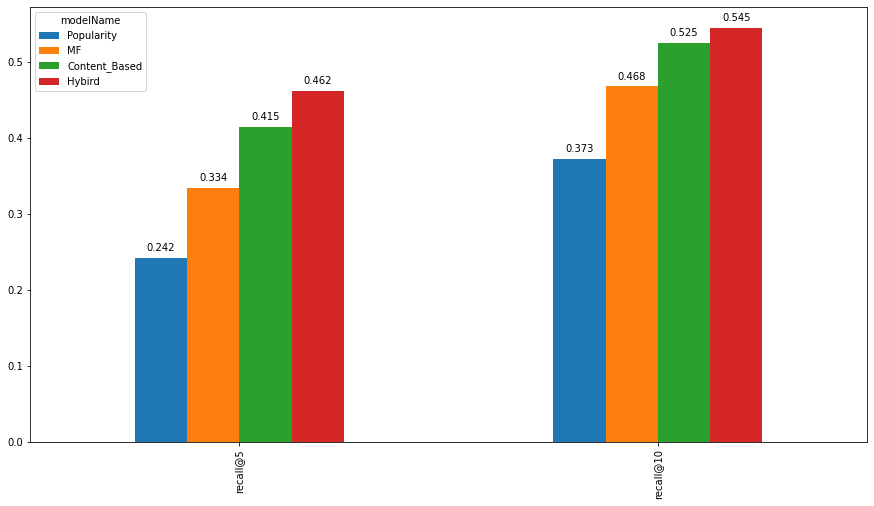

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline

ax = global_metrics_df.transpose().plot(kind="bar", figsize=(15,8))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width()/2., p.get_height()),
                ha = "center", va = "center", xytext=(0, 10), textcoords="offset points")
plt.show()